# Assignment 2 COMST
Ayse Arslan, Kristian van Kuijk, Carlos Soto Garcia-Delgado, Philip Mühlenfeld, and Ali Alsaeedi

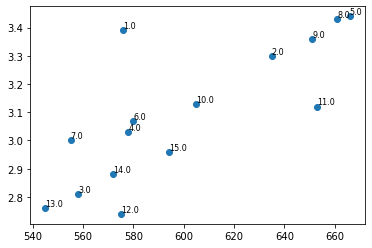

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load data
law = pd.read_csv('law.csv')

# Add observation column
law['observation'] = range(1, len(law) + 1)

# Plot data
fig, ax = plt.subplots()
ax.scatter(x=law['LSAT'], y=law['GPA'])
for i, row in law.iterrows():
    ax.text(row['LSAT'], row['GPA'], row['observation'], horizontalalignment='left', verticalalignment='bottom', fontsize=8)
plt.show()

#####  The nonparametric bootstrap distribution of the Pearson’s correlation coefficient between LSAT and GPA using B = 40000 bootstrap samples (lab exercise)

Observed correlation coefficient: 0.776
Bootstrap standard error: 0.134
95% Confidence interval: (0.459, 0.962)


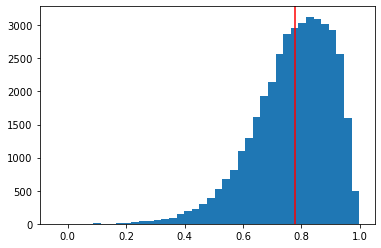

Wall time: 1min 10s


In [31]:
%%time
# Compute the observed correlation coefficient (correlation between LSAT and GPA)
obs_corr = law['LSAT'].corr(law['GPA'])

# Set the number of bootstrap samples
B = 40000

# Create an empty array to store the bootstrap samples
bootstrap_corr = np.zeros(B)

# Generate B bootstrap samples
for i in range(B):
    # Randomly sample/select with replacement from the data
    bootstrap_sample = law.sample(n=len(law), replace=True)
    # Compute the correlation coefficient of the bootstrap sample (like we did in the first lines)
    bootstrap_corr[i] = bootstrap_sample['LSAT'].corr(bootstrap_sample['GPA'])

# Compute the bootstrap standard error and 95% confidence interval (of the array filled with B correlation coefficients)
se_boot = np.std(bootstrap_corr)
lower_ci_boot = np.percentile(bootstrap_corr, 2.5)
upper_ci_boot = np.percentile(bootstrap_corr, 97.5)

# Print the results
print("Observed correlation coefficient: {:.3f}".format(obs_corr))
print("Bootstrap standard error: {:.3f}".format(se_boot))
print("95% Confidence interval: ({:.3f}, {:.3f})".format(lower_ci_boot, upper_ci_boot))

# Plot results
plt.hist(bootstrap_corr, bins=40)
plt.axvline(x=obs_corr, color='r', linewidth=1.5)
plt.show()

## 1) Recompute using the complete enumaration bootstrap

We will use a subset of the data since 15 data points means 77558760 samples, which is computationally too expensive. Therefore, we only use the first 10 data points.

###### Compute the samples

In [94]:
%%time
import numpy as np
import pandas as pd
from itertools import combinations_with_replacement

new_law = law[:10]
n = new_law.shape[0]

# All possible combinations
combs = combinations_with_replacement(range(n), n)

samples = []
for comb in combs:
    bootstrap_sample = new_law.iloc[list(comb), :]
    samples.append(bootstrap_sample)

print(len(samples))

92378
Wall time: 25 s


###### Compute the correlation coefficients and plot

92378
92368
Observed correlation coefficient: 0.813
Bootstrap standard error: 0.228
95% Confidence interval: (0.243, 0.999)


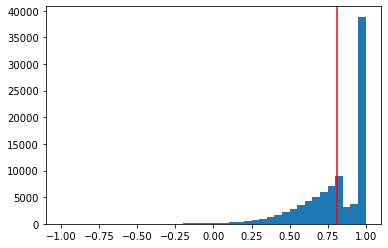

Wall time: 2min 44s


In [95]:
%%time

# Compute the Pearson correlation between LSAT and GPA for each bootstrap sample
corrs = [sample['LSAT'].corr(sample['GPA']) for sample in samples]
print(len(corrs))

obs_corr = new_law['LSAT'].corr(new_law['GPA'])

# Filter out NaN correlation coefficients since it is a smaller dataset and there may 
# have been fewer valid pairs of LSAT and GPA scores that could be used to calculate 
# the correlation coefficient, resulting in more NaN values
corrs = [corr for corr in corrs if not np.isnan(corr)]
print(len(corrs))

# Same code
se_boot = np.std(corrs)
lower_ci_boot = np.percentile(corrs, 2.5)
upper_ci_boot = np.percentile(corrs, 97.5)

print("Observed correlation coefficient: {:.3f}".format(obs_corr))
print("Bootstrap standard error: {:.3f}".format(se_boot))
print("95% Confidence interval: ({:.3f}, {:.3f})".format(lower_ci_boot, upper_ci_boot))

import matplotlib.pyplot as plt
plt.hist(bootstrap_corr, bins=40)
plt.axvline(x=obs_corr, color='r', linewidth=1.5)
plt.show()

Standard error increased because the dataset is of size 10 now and not 15. There is more variation in the resulting correlation coefficients as it provides less info. Also with the subset of the data, the analysis can have more outliers. 

## 2) Use Gray codes for compositions to speedup computations

## 3)  How much speedup can you get by using Gray codes? Show either experimentally or theoretically.

## 4) Which observation(s) do you need to remove from the sample to make the Monte Carlo and complete enumeration bootstrap look more similar?

In [60]:
import statsmodels.api as sm

# linear regression
X = sm.add_constant(law['LSAT'])
model = sm.OLS(law['GPA'], X).fit()

# Cook's distance
influence = model.get_influence()
cd = influence.cooks_distance[0]

threshold = 4/len(law)
outliers = law[cd > threshold]
outliers

,LSAT,GPA
0,576,3.39


## 5) Explain why you obtain difference results for Monte Carlo and complete enumeration bootstrap.